In [160]:
import WAN
import os
import mat73
dataset = 'authorshipData.mat' # store the human paper
# here the aim is to convert the text into WAN

In [161]:
import json
gpt_response = "responses.json"
gpt_papers = []
with open(gpt_response,'r') as f:
    response = f.readline()
    gpt_papers.append(json.loads(response))


# show the basic structure of original human expercet

In [162]:
human_data = mat73.loadmat(dataset)


In [163]:
print(human_data.keys())
for i in human_data["all_wans"]:
    print(i.shape)
print(human_data['function_words'])

for i in human_data["all_freqs"]:
    print(i.shape)
print(human_data["all_wans"][0][:,:,3][0],human_data["all_freqs"][0][:,3])

dict_keys(['all_authors', 'all_freqs', 'all_wans', 'function_words'])
(211, 211, 337)
(211, 211, 448)
(211, 211, 284)
(211, 211, 328)
(211, 211, 467)
(211, 211, 771)
(211, 211, 682)
(211, 211, 907)
(211, 211, 936)
(211, 211, 626)
(211, 211, 405)
(211, 211, 439)
(211, 211, 1022)
(211, 211, 299)
(211, 211, 212)
(211, 211, 595)
(211, 211, 415)
(211, 211, 613)
(211, 211, 423)
(211, 211, 366)
(211, 211, 555)
[['a'], ['bit'], ['couple'], ['aboard'], ['about'], ['above'], ['absent'], ['according'], ['accordingly'], ['across'], ['after'], ['against'], ['ahead'], ['albeit'], ['all'], ['along'], ['alongside'], ['although'], ['amid'], ['amidst'], ['among'], ['amongst'], ['an'], ['and'], ['another'], ['any'], ['anybody'], ['anyone'], ['anything'], ['around'], ['as'], ['aside'], ['astraddle'], ['astride'], ['at'], ['away'], ['bar'], ['barring'], ['because'], ['before'], ['behind'], ['below'], ['beneath'], ['beside'], ['besides'], ['between'], ['beyond'], ['both'], ['but'], ['by'], ['can'], ['certai

In [8]:
print(human_data["all_authors"])

[['abbott'], ['stevenson'], ['alcott'], ['alger'], ['allen'], ['austen'], ['bronte'], ['cooper'], ['dickens'], ['garland'], ['hawthorne'], ['james'], ['melville'], ['page'], ['thoreau'], ['twain'], ['doyle'], ['irving'], ['poe'], ['jewett'], ['wharton']]


In [9]:
human_data.keys()
print(human_data['all_wans'][0].shape)
function_words = [word[0] for word in human_data['function_words']]
print(len(function_words))


(211, 211, 337)
224


In [10]:
human_data['all_freqs'][0].shape

(211, 337)

# load chatgpt expercerts

In [166]:
def load_gpt(function_words,windowWidth,file = "responses.json"):
    gpt_response = file
    gpt_papers = []
    WANS = []
    
    wordcounts = []
    with open(gpt_response,'r') as f:
        while(True):
            response = f.readline()
            if response:
                try:
                    gpt_papers.append(json.loads(response))
                except:
                    print(response)
                    
            else:
                break
    for paper in gpt_papers:
        #paper = json.loads()
        papers = paper.items()
        for writer,novel in papers:
            
            # generate WAN for novel and store it in to gptWANs
            (text1Scores, text1Counts) = WAN.countFWs(WAN.cleanUp(novel),function_words,windowWidth)
            WAN1 = WAN.normalize(text1Scores) 
            
            WANS.append(WAN1)
            wordcounts.append(text1Counts)
    return wordcounts, WANS
            
            

In [167]:
wordcounts, WANS = load_gpt(function_words[:211],5) # obtain wans and word counts last 13 word is unnecessary

{"horatio alger": "It was a bright summer morning, and John had just finished his chores on the farm. He wiped the sweat from his brow and looked out at the vast expanse of land before him. He knew that he was meant for something more than just tilling the soil and caring for the animals. He had a dream, a dream of making something of himself, of becoming a successful businessman.\n\nJohn had always been a hard worker, and he knew that if he put his mind to it, he could achieve anything he wanted. He had read stories of men who had risen from poverty to great wealth through hard work and determination, and he was determined to do the same.\n\nWith this goal in mind, John set out to make his fortune. He started by saving every penny he could, working extra hours on the farm and taking odd jobs in town. He knew that he needed to save enough money to start his own business, and he was willing to do whatever it took to make it happen.\n\nAfter months of saving, John finally had enough mone

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




        Looking in window at word number 1 which is 'in'
        Looking in window at word number 2 which is 'the'
        Looking in window at word number 3 which is 'world'
        Looking in window at word number 4 which is 'that'
        Looking in window at word number 0 which is 'the'
        Looking in window at word number 1 which is 'world'
        Looking in window at word number 2 which is 'that'
        Looking in window at word number 3 which is 'you'
        Looking in window at word number 4 which is 'seek'
        Looking in window at word number 0 which is 'world'
        Looking in window at word number 1 which is 'that'
        Looking in window at word number 2 which is 'you'
        Looking in window at word number 3 which is 'seek'
        Looking in window at word number 4 which is 'to'
        Looking in window at word number 0 which is 'you'
        Looking in window at word number 1 which is 'seek'
        Looking in window at word number 2 which is 'to'
    

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [169]:
import numpy as np
print(len(WANS),np.array(wordcounts).shape)

146 (146, 211)


# convert Chatgpt to dataset

In [170]:
import pickle
import torch_geometric
from torch.nn.functional import normalize
import torch
import networkx as nx
from networkx import from_numpy_array
from torch_geometric.data import Data,Dataset
from torch_geometric.utils import from_networkx

In [171]:
Graphs = []
for i in range(len(wordcounts)):
    adj_matrix = np.array(WANS[i])
    
    
    graph = from_numpy_array(adj_matrix,create_using=nx.DiGraph)
    
    data = from_networkx(graph)
    edge_index = data.edge_index
    edge_attr = data.weight
    signal = torch.tensor(wordcounts[i],dtype =torch.float64 )
    
    signal = (signal-signal.mean())/(signal.std())
    
    g = Data(x = signal.reshape(-1,1), edge_index = edge_index,edge_attr = edge_attr,y = torch.tensor([[0]])) # i define chat gpt's label as zero
    Graphs.append(g)
########################################################################
# now include human novels into the dataset
print(len(Graphs))

146


In [172]:
for i in range(len(human_data["all_authors"])):
    print(human_data["all_authors"][i])
    author_excerpts = torch.tensor(human_data["all_wans"][i])
    
    num_papers = author_excerpts.shape[-1]
    for num in range(7):#num_papers): # keep balanced num between true/false samples
        adj_matrix = author_excerpts[:,:,num]
        signal = human_data["all_freqs"][i][:,num].reshape(-1,1)
        signal = torch.tensor(signal,dtype=torch.float64)
        signal = (signal-signal.mean())/(signal.std())
        y = torch.tensor([[1]])
        adj_matrix = np.array(adj_matrix)
        
        adj_matrix /= (adj_matrix.sum(axis = 1).reshape(-1,1)+0.0000001)
        graph = from_numpy_array(adj_matrix,create_using=nx.DiGraph)
       
        data = from_networkx(graph)
        edge_index = data.edge_index
        edge_attr = data.weight
        g = Data(x = signal, edge_index = edge_index,edge_attr = edge_attr,y = y) # i define chat gpt's label as zero
        Graphs.append(g)

['abbott']
['stevenson']
['alcott']
['alger']
['allen']
['austen']
['bronte']
['cooper']
['dickens']
['garland']
['hawthorne']
['james']
['melville']
['page']
['thoreau']
['twain']
['doyle']
['irving']
['poe']
['jewett']
['wharton']


In [173]:
# store data into pickle
with open("graph_dataset.txt",'wb') as f:
    pickle.dump(Graphs,f)

# Model GCNN

In [174]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

In [175]:
train_test = train_test_split(Graphs,train_size = 0.7,test_size = 0.3, shuffle=True)
print(len(Graphs),Graphs[12])

293 Data(x=[211, 1], edge_index=[2, 203], edge_attr=[203], y=[1, 1])


In [176]:
train_loader = DataLoader(train_test[0],batch_size = 16)
test_loader =  DataLoader(train_test[1],batch_size = 16)


In [177]:
for i in train_loader:
    print(i)
    

DataBatch(x=[3376, 1], edge_index=[2, 7018], edge_attr=[7018], y=[16, 1], batch=[3376], ptr=[17])
DataBatch(x=[3376, 1], edge_index=[2, 7369], edge_attr=[7369], y=[16, 1], batch=[3376], ptr=[17])
DataBatch(x=[3376, 1], edge_index=[2, 6386], edge_attr=[6386], y=[16, 1], batch=[3376], ptr=[17])
DataBatch(x=[3376, 1], edge_index=[2, 8366], edge_attr=[8366], y=[16, 1], batch=[3376], ptr=[17])
DataBatch(x=[3376, 1], edge_index=[2, 8347], edge_attr=[8347], y=[16, 1], batch=[3376], ptr=[17])
DataBatch(x=[3376, 1], edge_index=[2, 7294], edge_attr=[7294], y=[16, 1], batch=[3376], ptr=[17])
DataBatch(x=[3376, 1], edge_index=[2, 4356], edge_attr=[4356], y=[16, 1], batch=[3376], ptr=[17])
DataBatch(x=[3376, 1], edge_index=[2, 6827], edge_attr=[6827], y=[16, 1], batch=[3376], ptr=[17])
DataBatch(x=[3376, 1], edge_index=[2, 6491], edge_attr=[6491], y=[16, 1], batch=[3376], ptr=[17])
DataBatch(x=[3376, 1], edge_index=[2, 6936], edge_attr=[6936], y=[16, 1], batch=[3376], ptr=[17])
DataBatch(x=[3376, 1

In [178]:
from torch.nn import Module,Linear,ReLU,Dropout,Sigmoid,ModuleList
from torch.nn.functional import tanh
from torch_geometric.nn import GCNConv
class GCNN(Module):
    def __init__(self,in_channel,hidden_channels,out_channel,dropout_rate,resize_num =211 ):
        super().__init__()
        self.convs = []
        
        prev_channels = in_channel
        for channel in hidden_channels:
            self.convs.append(GCNConv(prev_channels,channel))
            prev_channels = channel
        self.convs = torch.nn.ModuleList(self.convs)
        self.linear = Linear(prev_channels*resize_num,out_channel)
        self.relu = ReLU()
        self.dropout = Dropout(dropout_rate)
        self.sigmoid = Sigmoid()
        self.tanh = tanh
        
    def forward(self,x,edge_index,edge_attr,batch_size = 128):
        #print(x.reshape(batch_size,-1))
        for i, conv in enumerate(self.convs):
            
            
            x = conv(x,edge_index,edge_attr)
            x = self.dropout(x)
            if i != len(self.convs)-1:
                x = self.relu(x)
        #print(x.reshape(batch_size,-1))
        x = x.reshape(batch_size,-1)
        #print(x)
        x = self.tanh(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        #print(x)
        
        
        return x

            
            
model = GCNN(1,[16,32,64,32,16,1],1,0.3)

    
    
    

In [179]:
loss = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
def train(model,criteria,optimizer,epoch,train_loader,test,test_loader):
    train_accs = []
    test_accs = []
    for i in range(epoch):
        losses = 0
        total_count = 0
        accs = 0
        for batch in train_loader:
            #print(batch)
            optimizer.zero_grad()
            x = batch.x
            
            edge_index = batch.edge_index
            edge_attr = batch.edge_attr
           
            prediction = model.forward(x.float(),edge_index,edge_attr,batch.y.shape[0]).float()
            
            #print(prediction)
            
            
            loss = criteria(prediction,batch.y.float())
            loss.backward()
            optimizer.step()
            #accs = test(model,test_loader)
            losses+=loss
            total_count+=1
            
            prediction = prediction > 0.5
            
            
            accs += (prediction == batch.y).sum()/prediction.shape[0]
            
        test_acc = test(model,test_loader)    
        print("epoch ",i," is ",loss/total_count," accs is ", accs/total_count)#," test acc ",accs)
        train_accs.append(accs/total_count)
        test_accs.append(test_acc)
    return train_accs, test_accs

def test(model,test_loader):
    total_count = 0
    accs = 0
    for batch in test_loader:
        x = batch.x
        edge_index = batch.edge_index
        edge_attr = batch.edge_attr
        prediction = model.forward(x.float(),edge_index,edge_attr,batch.y.shape[0]).float()
        total_count+=1    
        prediction = prediction > 0.5            
        accs += (prediction == batch.y).sum()/prediction.shape[0]
    print("test  accs is ", accs/total_count)#," test acc ",accs)
    return accs/total_count
    
train_accs, test_accs = train(model,loss,optimizer,200,train_loader,test,test_loader)        
        

/Users/asdfasd/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


test  accs is  tensor(0.4271)
epoch  0  is  tensor(0.0527, grad_fn=<DivBackward0>)  accs is  tensor(0.5329)
test  accs is  tensor(0.5417)
epoch  1  is  tensor(0.0521, grad_fn=<DivBackward0>)  accs is  tensor(0.5603)
test  accs is  tensor(0.8229)
epoch  2  is  tensor(0.0516, grad_fn=<DivBackward0>)  accs is  tensor(0.6409)
test  accs is  tensor(0.7708)
epoch  3  is  tensor(0.0501, grad_fn=<DivBackward0>)  accs is  tensor(0.7156)
test  accs is  tensor(0.8125)
epoch  4  is  tensor(0.0489, grad_fn=<DivBackward0>)  accs is  tensor(0.7359)
test  accs is  tensor(0.8333)
epoch  5  is  tensor(0.0453, grad_fn=<DivBackward0>)  accs is  tensor(0.8258)
test  accs is  tensor(0.8125)
epoch  6  is  tensor(0.0420, grad_fn=<DivBackward0>)  accs is  tensor(0.8499)
test  accs is  tensor(0.8542)
epoch  7  is  tensor(0.0390, grad_fn=<DivBackward0>)  accs is  tensor(0.8332)
test  accs is  tensor(0.8542)
epoch  8  is  tensor(0.0333, grad_fn=<DivBackward0>)  accs is  tensor(0.8654)
test  accs is  tensor(0.8438

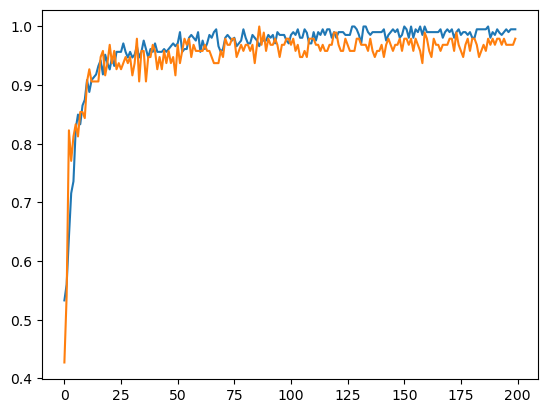

In [182]:
import matplotlib.pyplot as plt
plt.plot(train_accs)
plt.plot(test_accs,'-')
plt.show()